In [0]:
#first shit
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-eu.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:

#second shit
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

In [0]:

#third shit
import findspark
findspark.init("spark-2.4.4-bin-hadoop2.7")# SPARK_HOME
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
import pyspark.sql as sparksql
sc = spark.sparkContext
# ---
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoderEstimator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import mean
import pandas as pd
import matplotlib.pyplot as plt

In [161]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
import os
from google.colab import drive
drive.mount('/content/gdrive')
workdir = '/content/gdrive/My Drive/IFABI-2019/Data Science - Project 03/data/'


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


statistitk:
1. age histogramme (stroke 0/1)
2. violin plots
3. correlation heatmap
4. boxplots
----
imputation: one hot encoder
----
prediction - logistische regression (spark docu)
  - imputation
  - deletion
classifier - descision tree (?)
clustering - k means (spark)
----
cluster analysieren

In [0]:
trainpath = "/content/gdrive/My Drive/train_2v.csv"
testpath = "/content/gdrive/My Drive/test_2v.csv"

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("stroke") \
    .getOrCreate()

train = spark.read.csv(trainpath, inferSchema=True,header=True)
test  = spark.read.csv(testpath,  inferSchema=True,header=True)

In [163]:
train.groupBy('stroke').count().show()
train.createOrReplaceTempView('table')

+------+-----+
|stroke|count|
+------+-----+
|     1|  783|
|     0|42617|
+------+-----+



In [0]:
train_f = train.na.fill('NoInfo', subset=['smoking_status'])
test_f = test.na.fill('NoInfo', subset=['smoking_status'])

In [165]:
train.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



In [166]:
train.describe().show()

+-------+-----------------+------+------------------+-------------------+-------------------+------------+---------+--------------+------------------+------------------+---------------+-------------------+
|summary|               id|gender|               age|       hypertension|      heart_disease|ever_married|work_type|Residence_type| avg_glucose_level|               bmi| smoking_status|             stroke|
+-------+-----------------+------+------------------+-------------------+-------------------+------------+---------+--------------+------------------+------------------+---------------+-------------------+
|  count|            43400| 43400|             43400|              43400|              43400|       43400|    43400|         43400|             43400|             41938|          30108|              43400|
|   mean|36326.14235023042|  null| 42.21789400921646|0.09357142857142857|0.04751152073732719|        null|     null|          null|104.48274999999916|28.605038390004545|       

In [167]:
test.describe().show()

+-------+------------------+------+------------------+-------------------+--------------------+------------+---------+--------------+------------------+------------------+---------------+
|summary|                id|gender|               age|       hypertension|       heart_disease|ever_married|work_type|Residence_type| avg_glucose_level|               bmi| smoking_status|
+-------+------------------+------+------------------+-------------------+--------------------+------------+---------+--------------+------------------+------------------+---------------+
|  count|             18601| 18601|             18601|              18601|               18601|       18601|    18601|         18601|             18601|             18010|          12850|
|   mean| 36747.36804472878|  null|42.056504489006024|0.09316703403042847|0.048061932154185256|        null|     null|          null| 104.3863593355191|28.545324819544625|           null|
| stddev|21053.151123778684|  null|22.528017622414048|0.2906

In [168]:
for feature in ['work_type','Residence_type','smoking_status','heart_disease','ever_married',"gender"]:
  for job in list(spark.sql("SELECT DISTINCT %s \
            FROM table"%feature).toPandas()[feature]):
    print(job)
    spark.sql(f"SELECT {feature}, COUNT({feature}) as {feature}, COUNT({feature})*100/(\
              SELECT COUNT({feature}) \
              FROM table \
              WHERE {feature} == '{job}') as percentage \
            FROM table \
            WHERE stroke== 1 AND {feature} = '{job}' GROUP BY {feature}").show()

for age in range(0,101,10):
  print(age, spark.sql(f"SELECT COUNT(age)*100/(\
              SELECT COUNT(age) \
              FROM table \
              WHERE stroke ==1) as percentage \
            FROM table \
            WHERE stroke == 1 AND age<={age}").toPandas()["percentage"][0])

Never_worked
+---------+---------+----------+
|work_type|work_type|percentage|
+---------+---------+----------+
+---------+---------+----------+

Self-employed
+-------------+---------+------------------+
|    work_type|work_type|        percentage|
+-------------+---------+------------------+
|Self-employed|      251|3.6949801266009126|
+-------------+---------+------------------+

Private
+---------+---------+------------------+
|work_type|work_type|        percentage|
+---------+---------+------------------+
|  Private|      441|1.7757912539260692|
+---------+---------+------------------+

children
+---------+---------+-------------------+
|work_type|work_type|         percentage|
+---------+---------+-------------------+
| children|        2|0.03248862897985705|
+---------+---------+-------------------+

Govt_job
+---------+---------+------------------+
|work_type|work_type|        percentage|
+---------+---------+------------------+
| Govt_job|       89|1.6360294117647058|
+------

In [0]:
# I draw a sample from the RDD to do better statistics with pandas.
n = train.count() # n can be chosen as a data frame size with wich I can work without using spark. Here it is the whole frame.
p = n/train.count()
D = train.sample(False, p).toPandas()

In [170]:
# somkers who did not fill the field and had a stroke. their age.
#sum(((D["smoking_status"] == "not") & (D["stroke"] == 1))),sum((D["smoking_status"] == "not"))
len(D[(D["smoking_status"] == "not") & (D["stroke"] == 1)]["age"]), sum(D[(D["smoking_status"] == "not") & (D["stroke"] == 1)]["age"] >= 50)

(0, 0)

In [171]:
D["smoking_status"] = D["smoking_status"].fillna("not")
print("\ndifference of genders\n",\
      D[D["gender"] == "Male"].mean() - D[D["gender"] == "Female"].mean())
print("\ndifference of residence\n",\
      D[D["Residence_type"] == "Rural"].mean() - D[D["Residence_type"] == "Urban"].mean())
print("\ndifference of smoking behavior\n",\
      "\nnot\n",            D[D["smoking_status"] == "not"].mean(),\
      "\nnever smoked\n",   D[D["smoking_status"] == "never smoked"].mean(),\
      "\nformerly smoked\n",D[D["smoking_status"] == "formerly smoked"].mean(),\
      "\nsmokes\n",         D[D["smoking_status"] == "smokes"].mean())


difference of genders
 id                   72.555921
age                  -1.267977
hypertension          0.014224
heart_disease         0.035644
avg_glucose_level     3.141377
bmi                  -0.347457
stroke                0.003067
dtype: float64

difference of residence
 id                  -5.072294
age                 -0.058491
hypertension         0.001819
heart_disease        0.001167
avg_glucose_level   -0.001164
bmi                  0.058260
stroke              -0.000598
dtype: float64

difference of smoking behavior
 
not
 id                   35712.765272
age                     29.267725
hypertension             0.040099
heart_disease            0.028890
avg_glucose_level       98.353068
bmi                     25.330592
stroke                   0.010909
dtype: float64 
never smoked
 id                   36439.345418
age                     45.565626
hypertension             0.108889
heart_disease            0.037625
avg_glucose_level      105.171795
bmi             

In [0]:
S = D[D["stroke"] == 1]
H = D[D["stroke"] == 0]

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, 'no stroke - avg_glucose_level')

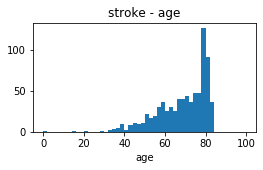

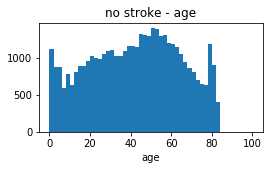

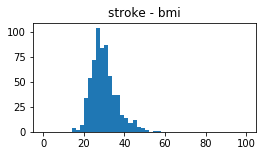

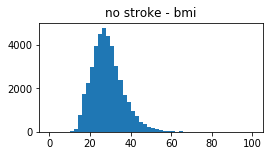

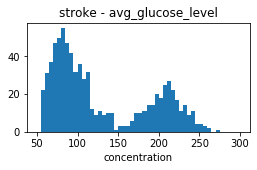

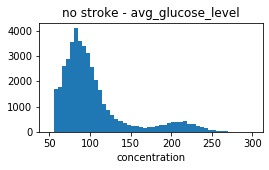

In [173]:
plt.figure(figsize=(4,2))
_=plt.hist(S["age"],rwidth =1.0, range = (0,100),bins =50)
plt.xlabel("age")
plt.title("stroke - age")
plt.figure(figsize=(4,2))
_=plt.hist(H["age"],rwidth =1.0, range = (0,100),bins =50)
plt.xlabel("age")
plt.title("no stroke - age")

plt.figure(figsize=(4,2))
_ = plt.hist(S["bmi"],rwidth =1.0, range = (0,100),bins =50)
plt.title("stroke - bmi")
plt.figure(figsize=(4,2))
_ = plt.hist(H["bmi"],rwidth =1.0, range = (0,100),bins =50)
plt.title("no stroke - bmi")

plt.figure(figsize=(4,2))
_ = plt.hist(S["avg_glucose_level"],rwidth =1.0, range = (50,300),bins =50)
plt.xlabel("concentration")
plt.title("stroke - avg_glucose_level")
plt.figure(figsize=(4,2))
_ = plt.hist(H["avg_glucose_level"],rwidth =1.0, range = (50,300),bins =50)
plt.xlabel("concentration")
plt.title("no stroke - avg_glucose_level")
# levels over 160 seem to stem from another mean, further investigations.

In [0]:
GLCH = S[S["avg_glucose_level"] > 160]
GLCL = S[S["avg_glucose_level"] <= 160]

checking features for stroke and glucose above 160


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, 'stroke, low glucose - bmi')

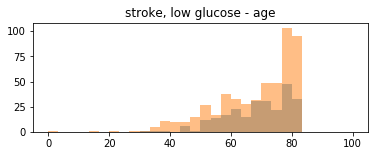

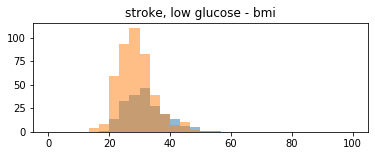

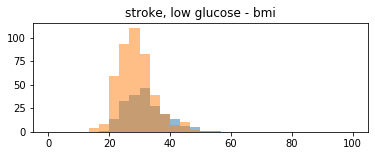

In [175]:
print("checking features for stroke and glucose above 160")
plt.figure(figsize=(6,2))
_=plt.hist(GLCH["age"],rwidth =1.0, range = (0,100),bins =30, alpha=0.5)
plt.title("stroke, high glucose - age")
#plt.figure(figsize=(6,2))
_=plt.hist(GLCL["age"],rwidth =1.0, range = (0,100),bins =30, alpha=0.5)
plt.title("stroke, low glucose - age")

plt.figure(figsize=(6,2))
_=plt.hist(GLCH["bmi"],rwidth =1.0, range = (0,100),bins =30, alpha=0.5)
plt.title("stroke, high glucose - bmi")
#plt.figure(figsize=(6,2))
_=plt.hist(GLCL["bmi"],rwidth =1.0, range = (0,100),bins =30, alpha=0.5)
plt.title("stroke, low glucose - bmi")

plt.figure(figsize=(6,2))
_=plt.hist(GLCH["bmi"],rwidth =1.0, range = (0,100),bins =30, alpha=0.5)
plt.title("stroke, high glucose - bmi")
#plt.figure(figsize=(6,2))
_=plt.hist(GLCL["bmi"],rwidth =1.0, range = (0,100),bins =30, alpha=0.5)
plt.title("stroke, low glucose - bmi")

In [176]:
GLCH.mean(), GLCL.mean()

(id                   37299.535156
 age                     68.710938
 hypertension             0.304688
 heart_disease            0.312500
 avg_glucose_level      209.210625
 bmi                     31.905797
 stroke                   1.000000
 dtype: float64, id                   36540.755218
 age                     67.867780
 hypertension             0.231499
 heart_disease            0.184061
 avg_glucose_level       90.901917
 bmi                     28.900688
 stroke                   1.000000
 dtype: float64)

In [0]:
D["diabetes"] = D["avg_glucose_level"] > 160

In [0]:
diaY = D[D["diabetes"]]
diaN = D[~D["diabetes"]]

Text(0.5, 1.0, 'no diabetes - age')

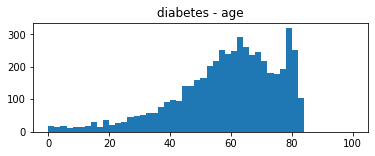

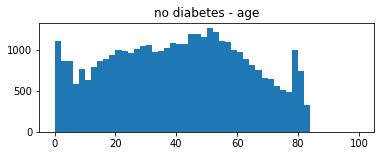

In [179]:
plt.figure(figsize=(6,2))
_=plt.hist(diaY["age"],rwidth =1.0, range = (0,100),bins =50)
plt.title("diabetes - age")
plt.figure(figsize=(6,2))
_=plt.hist(diaN["age"],rwidth =1.0, range = (0,100),bins =50)
plt.title("no diabetes - age")

In [0]:
seniors = D[D["age"] > 76]
nonseniors = D[D["age"] <= 76]

In [181]:
seniors.mean(), nonseniors.mean() 

(id                   36233.430323
 age                     79.441935
 hypertension             0.237419
 heart_disease            0.199677
 avg_glucose_level      120.305671
 bmi                     28.064726
 stroke                   0.090000
 diabetes                 0.248387
 dtype: float64, id                   36333.274045
 age                     39.354506
 hypertension             0.082506
 heart_disease            0.035806
 avg_glucose_level      103.265602
 bmi                     28.645727
 stroke                   0.012506
 diabetes                 0.108313
 dtype: float64)

In [182]:
diaY.mean(), diaN.mean(), len(diaY.index), len(diaN.index), sum(diaY["stroke"] == 1), sum(diaN["stroke"] == 1)

(id                   38530.528724
 age                     58.209722
 hypertension             0.234469
 heart_disease            0.140019
 avg_glucose_level      206.807108
 bmi                     33.191722
 stroke                   0.049854
 diabetes                 1.000000
 dtype: float64, id                   36030.323089
 age                     40.071859
 hypertension             0.074664
 heart_disease            0.035097
 avg_glucose_level       90.751257
 bmi                     28.031257
 stroke                   0.013772
 diabetes                 0.000000
 dtype: float64, 5135, 38265, 256, 527)

In [183]:
D[~((D["smoking_status"] != "not") & (D["smoking_status"] != "never smoked"))].mean(),D[((D["smoking_status"] != "not") & (D["smoking_status"] != "never smoked"))].mean()

(id                   36110.236429
 age                     38.183391
 hypertension             0.077730
 heart_disease            0.033668
 avg_glucose_level      102.083210
 bmi                     27.786814
 stroke                   0.014619
 diabetes                 0.097768
 dtype: float64, id                   36776.925649
 age                     50.641409
 hypertension             0.126645
 heart_disease            0.076414
 avg_glucose_level      109.492674
 bmi                     30.362026
 stroke                   0.025187
 diabetes                 0.161224
 dtype: float64)

In [184]:
D[((D["smoking_status"] != "not") & (D["smoking_status"] != "never smoked") & (D["age"] > 76) & (D["avg_glucose_level"] > 160))].mean(), D[~((D["smoking_status"] != "not") & (D["smoking_status"] != "never smoked") & (D["age"] > 76) & (D["avg_glucose_level"] > 160))].mean()

(id                   39026.308157
 age                     79.407855
 hypertension             0.280967
 heart_disease            0.268882
 avg_glucose_level      209.102870
 bmi                     29.509667
 stroke                   0.096677
 diabetes                 1.000000
 dtype: float64, id                   36305.390652
 age                     41.932076
 hypertension             0.092131
 heart_disease            0.045810
 avg_glucose_level      103.678709
 bmi                     28.598521
 stroke                   0.017437
 diabetes                 0.111542
 dtype: float64)

In [185]:
sum(D["stroke"] == 1)

783

In [186]:
corr = seniors[["stroke", "age", "bmi", "avg_glucose_level", "hypertension", "heart_disease"]].corr()
corr.style.background_gradient(cmap='coolwarm')

In [187]:
corr = D[["stroke", "age", "bmi", "avg_glucose_level", "hypertension", "heart_disease"]].corr()
corr.style.background_gradient(cmap='coolwarm')

In [188]:
corr = nonseniors[["stroke", "age", "bmi", "avg_glucose_level", "hypertension", "heart_disease"]].corr()
corr.style.background_gradient(cmap='coolwarm')

In [189]:
list(set(D["work_type"]))

['Private', 'Self-employed', 'Never_worked', 'Govt_job', 'children']

In [190]:
F=D.copy()
F["Residence_type"] = D["Residence_type"] == "Urban"
F["ever_married"] = D["ever_married"] == "Yes"
F["smoking_status"] = ((D["smoking_status"] != "not") & (D["smoking_status"] != "never smoked"))
F["work_type"] = ((D["work_type"] != "children") & (D["work_type"] != "Never_worked"))
F

id  gender   age  ...  smoking_status  stroke  diabetes
0      30669    Male   3.0  ...           False       0     False
1      30468    Male  58.0  ...           False       0     False
2      16523  Female   8.0  ...           False       0     False
3      56543  Female  70.0  ...            True       0     False
4      46136    Male  14.0  ...           False       0      True
...      ...     ...   ...  ...             ...     ...       ...
43395  56196  Female  10.0  ...           False       0     False
43396   5450  Female  56.0  ...            True       0      True
43397  28375  Female  82.0  ...            True       0     False
43398  27973    Male  40.0  ...           False       0     False
43399  36271  Female  82.0  ...           False       0     False

[43400 rows x 13 columns]

In [196]:
corr = F[["stroke","age","hypertension","heart_disease","ever_married","work_type","Residence_type","avg_glucose_level","bmi","smoking_status"]].corr()
corr.style.background_gradient(cmap='coolwarm')